In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import ParameterMapper
from pyfoomb.utils import Helpers

from pyfoomb import LossCalculator

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [2]:
import matplotlib
from matplotlib import pyplot
import numpy
from scipy.spatial import distance
import time

# Set seed of random number generator for reproducibility
numpy.random.seed(666)

# Model calibration with constraints (except from box-bounds)

This notebook demonstrates how arbitrary constraints can be constructed from parameter values. This is shown for the `Caretaker`s method `estimate_parallel_MC_sampling()`. Constraints will be constructed from two yield parameters of a bioprocess model and the impact of parameter correlations obtained from MC sampling is compared.

### Some helper functions for this notebook

In [3]:
# Creates a noisy dataset, based on a forward simulation
def noisy_samples(simulations, samples=5, rel_err=0.05, abs_err=0.05, repetitions=3, with_errors=True):
    artifical_data = []
    
    # get joint time points
    t_all = Helpers.get_unique_timepoints(simulations)

    # iterate over simulations
    for simulation in simulations:
        
        _name = simulation.name
        _replicate_id = simulation.replicate_id
        _t_samples = numpy.random.choice(simulation.timepoints, size=samples, replace=False)
        _sample_idxs = numpy.in1d(simulation.timepoints, _t_samples)
        _timepoints = simulation.timepoints[_sample_idxs]
        _values = simulation.values[_sample_idxs]
        
        # generate random samples
        _rnd_values = [
            numpy.random.normal(loc=_values, scale=abs(_values*rel_err+abs_err)) 
            for _ in range(repetitions)
        ]
        
        # create new Measurement object
        _measurement = Measurement(
            name=_name, 
            replicate_id=_replicate_id,
            timepoints=_timepoints, 
            values=numpy.mean(_rnd_values, axis=0),
            errors=numpy.std(_rnd_values, ddof=1, axis=0) if with_errors else None,
        )
        artifical_data.append(_measurement)
        
    return artifical_data


def make_experiment(caretaker:Caretaker, tfinal:float, samples:int=3, show:bool=True):
    
    simulation = caretaker.simulate(t=tfinal)
    data = noisy_samples(caretaker.simulate(t=numpy.arange(tfinal*4)/4), samples=samples)
    if show:
        _ncols = len(set([_item.name for _item in simulation]))
        _ = Visualization.show_kinetic_data(simulation, ncols=_ncols)
        _ncols = len(set([_item.name for _item in data]))
        _ = Visualization.show_kinetic_data(data, ncols=_ncols)

    return data, simulation

# Bioprocess model


First, the bioprocess model is defined. This model is also used to generate some noisy artifical data to demonstrate the parameter estimation process.

In [4]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):
        
    def specific_growth_rate_mu(self, t, y):
        P, S, X = y
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        mu = mu_max * S / (kS + S)
        return mu
    
    def specific_production_rate_qP(self, t, y):
        P, S, X = y
        YPX = self.model_parameters['YPX']
        mu = self.specific_growth_rate_mu(t, y)
        qP = YPX * mu
        return qP
    
    def specific_substrate_consumption_rate_qS(self, t, y):
        P, S, X = y
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = 1/YXS * mu + 1/YPS * qP
        return qS
    
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = self.specific_substrate_consumption_rate_qS(t, y)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.6,
    'YPS' : 0.4,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}

# Instantiates are caretaker with two replicate_ids
caretaker = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

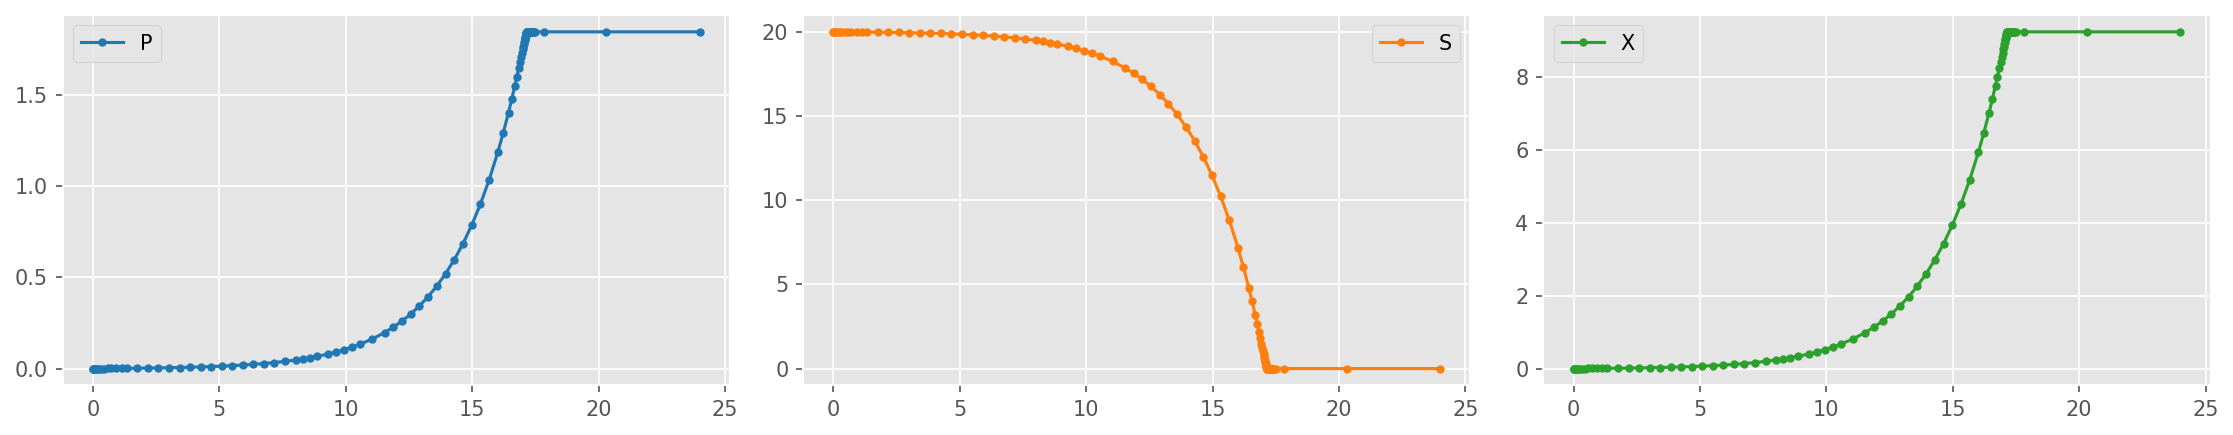

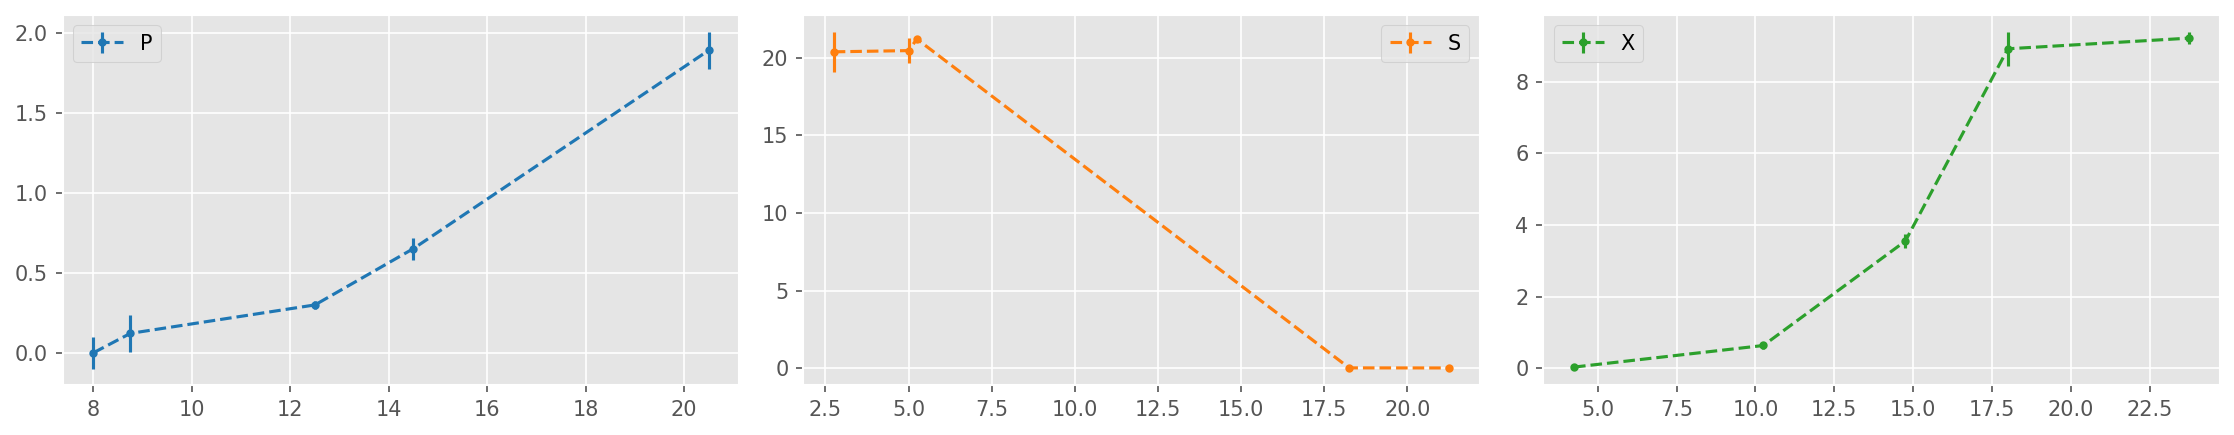

In [5]:
# Generates noisy artificial data from the simulation
data, simulation = make_experiment(caretaker, samples=5, tfinal=24)

# Parameter estimation
As usual, the `unknowns` and corresponding `bounds` have to specified for the estimation job.

In [6]:
# Defines the unknowns to be estimated, as well as corresponding bounds
unknowns = [
    'kS', 
    'mu_max', 
    'YXS', 
    'YPS', 
    'YPX',
]

bounds = [
    (0.01, 1.0),
    (0.1, 1.0),
    (0.1, 1.0),
    (0.1, 1.0),
    (0.1, 1.0),
]

Instead of running a single parameter estimation and approximate the corresponding estimate errors by FIM, another possibility is run many estimations from different realisations of the measurement data which are in this case though of as random numbers.

With a sufficently high number of re-sampled measurement data, the resulting empirical distributions of parameter estimations represent a non-linear error propagation from the measurement errors to the estimates.

In [7]:
# The convergence criterion for the parallel estimation.
# Will be less strict that the default one (which is 1e-6) to reduce runtimes in this notebook
rtol = 1e-2

mc_samples = 125

In [8]:
# Using default settings
mc_estimates = caretaker.estimate_parallel_MC_sampling(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    rtol_islands=rtol,
    report_level=1,
    mc_samples=mc_samples,
)

..........................................
-----------------------------------------------
Total runtime was 7.33 min.
Convergence ratio was 100.0 %.


Now consider the constraint that the sum of `YPS` and `YXS` cannot exceed one. Of course, such constraint is model specific, and depends also on the units for the yield coefficients.

To implement this contraint, one needs to subclass the `LossCalculator` and define methods evaluating the constraints, i.e. returning `True` or `False` is the constraint is met or violated, respectively. For each contraint, one corresponding method must be implemented.

Importantly, the method `check_constraints()` shall return a list of booleans, which indicate the violation of the defined constraints.

Practically, in case any constraint is violated, the `LossCalculator` will return an infinite loss to the optimizer.

In [9]:
class ConstrainedLossCalculator_1(LossCalculator):
    
    def constraint_1(self) -> bool:
        YPS = self.current_parameters['YPS']
        YXS = self.current_parameters['YXS']
        return (YXS + YPS) <= 1
    
    def check_constraints(self):
        con_1 = self.constraint_1()
        return [con_1,]

To consider the constrained optimization probel, one needs to provide the new class `ConstrainedLossCalculator` via the keyword argument `loss_calculator` to the `Caretaker`'s method `estimate_parallel` or `estimate_parallel_MC_sampling`.

In [10]:
mc_estimates_constr_1 = caretaker.estimate_parallel_MC_sampling(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    rtol_islands=rtol,
    report_level=1,
    mc_samples=mc_samples,
    loss_calculator=ConstrainedLossCalculator_1,
)

..........................................
-----------------------------------------------
Total runtime was 7.26 min.
Convergence ratio was 100.0 %.


Another constrained variant would be to demand `YXS` + `YPS` = 1 (with relative tolerance of `1e-2`).

In [11]:
class ConstrainedLossCalculator_2(LossCalculator):
    
    def constraint_1(self) -> bool:
        YPS = self.current_parameters['YPS']
        YXS = self.current_parameters['YXS']
        return numpy.allclose((YXS + YPS), 1, rtol=1e-2)
    
    def check_constraints(self):
        con_1 = self.constraint_1()
        return [con_1,]

In [12]:
mc_estimates_constr_2 = caretaker.estimate_parallel_MC_sampling(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    rtol_islands=rtol,
    report_level=1,
    mc_samples=mc_samples,
    loss_calculator=ConstrainedLossCalculator_2,
)

.

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


.........................................
-----------------------------------------------
Total runtime was 5.24 min.
Convergence ratio was 100.0 %.


# Compare the results

### Collect the different MC sampling results

In [13]:
estimates = [
    mc_estimates,
    mc_estimates_constr_1,
    mc_estimates_constr_2,
]

### Compare pairwise parameter correlations for the unconstraint and constraint fits

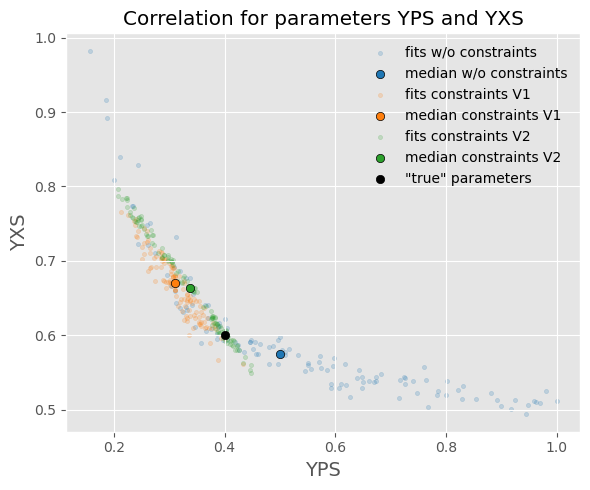

In [14]:
x = 'YPS'
y = 'YXS'

fig, ax = pyplot.subplots(dpi=100, figsize=(6, 5))

for _estimates, _color, _i in zip(estimates, matplotlib.cm.get_cmap('tab10').colors, range(len(estimates))):
    
    if _i == 0:
        label = 'w/o constraints'
    else:
        label = f'constraints V{_i}'
    
    
    ax.scatter(
        _estimates[x], _estimates[y], 
        alpha=0.2, marker='.', color=_color, zorder=0, label=f'fits {label}',
    )
    ax.scatter(
        numpy.median(_estimates[x]), numpy.median(_estimates[y]), 
        color=_color, edgecolor='black', zorder=1, label=f'median {label}',
    )
ax.scatter(
    model_parameters[x], model_parameters[y], 
    color='black', zorder=1, label='"true" parameters',
)
ax.set_xlabel(x, size=14)
ax.set_ylabel(y, size=14)
ax.set_title(f'Correlation for parameters {x} and {y}')
ax.legend(frameon=False)
fig.tight_layout()

### Evaluate medians of the unconstrained and constrained MC fits

In [15]:
for _i, _estimates in enumerate(estimates):
    _medians = {_p : numpy.median(_estimates[_p]) for _p in unknowns}
    if _i == 0:
        info = 'no constraints'
    else:
        info = f'constraints V{_i}'
    _negLL = caretaker.loss_function(_medians, 'negLL', data)
    _eucl_dist = distance.euclidean([model_parameters[_p] for _p in unknowns], [_medians[_p] for _p in unknowns])
    print(info)
    print(f'\tnegative log-likelihood for medians: {_negLL}')
    print(f'\tEuclidean distance between "true" values and medians: {_eucl_dist}\n')

no constraints
	negative log-likelihood for medians: 89.86862231441746
	Euclidean distance between "true" values and medians: 0.4938190190929774

constraints V1
	negative log-likelihood for medians: 89.88376477326335
	Euclidean distance between "true" values and medians: 0.5412703726514758

constraints V2
	negative log-likelihood for medians: 90.7478365000161
	Euclidean distance between "true" values and medians: 0.5975201800063261



### Compare the fits with the data and ground truth

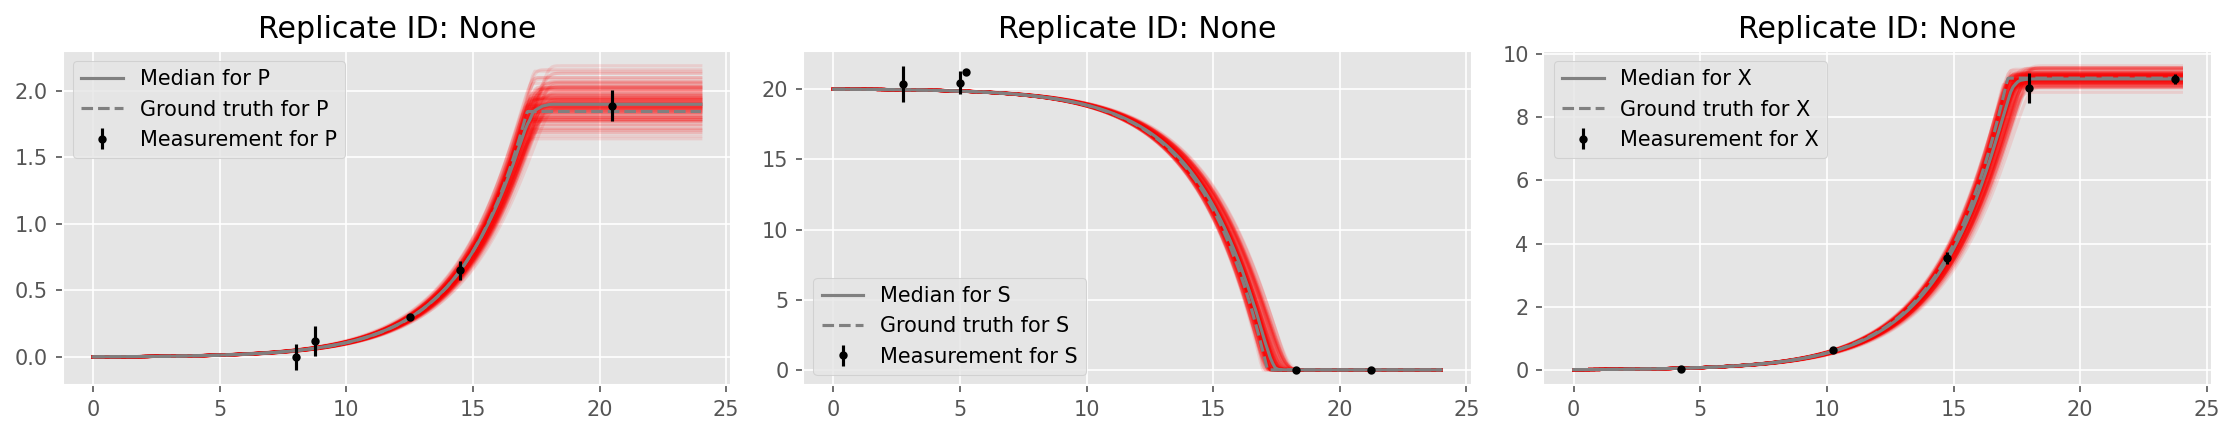

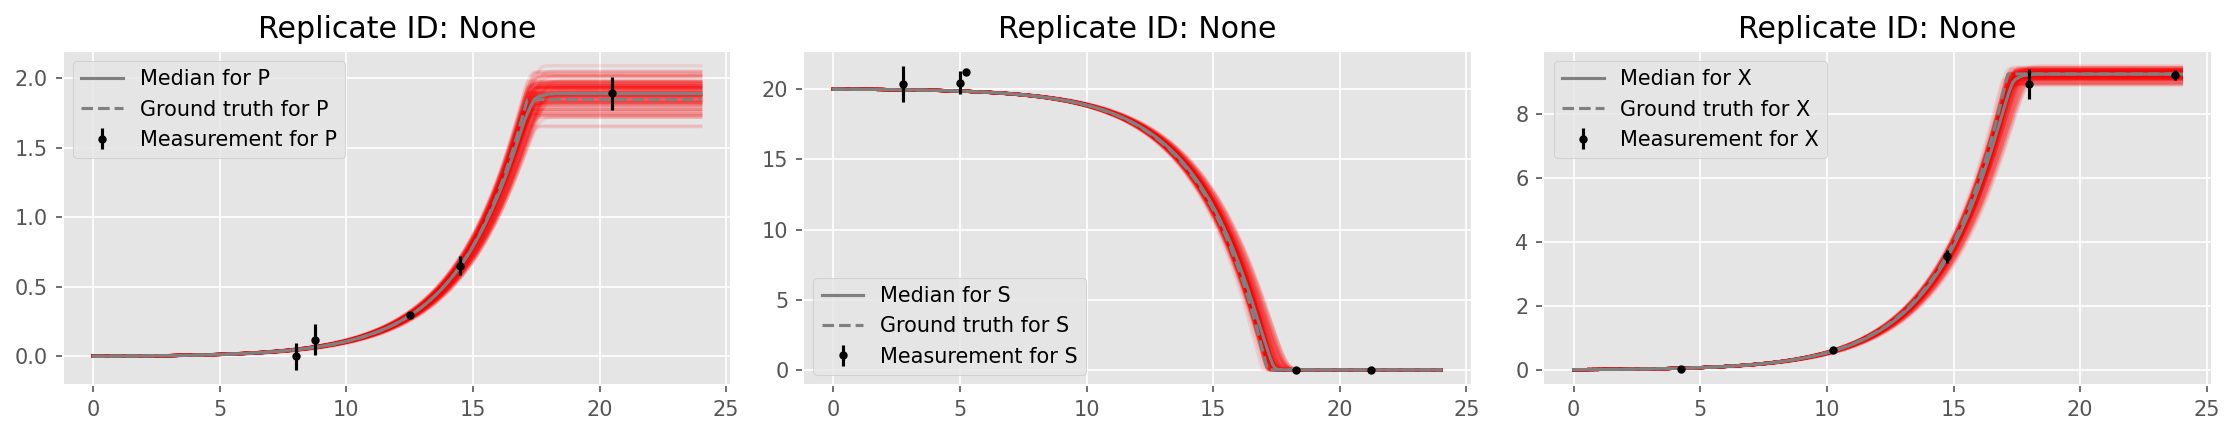

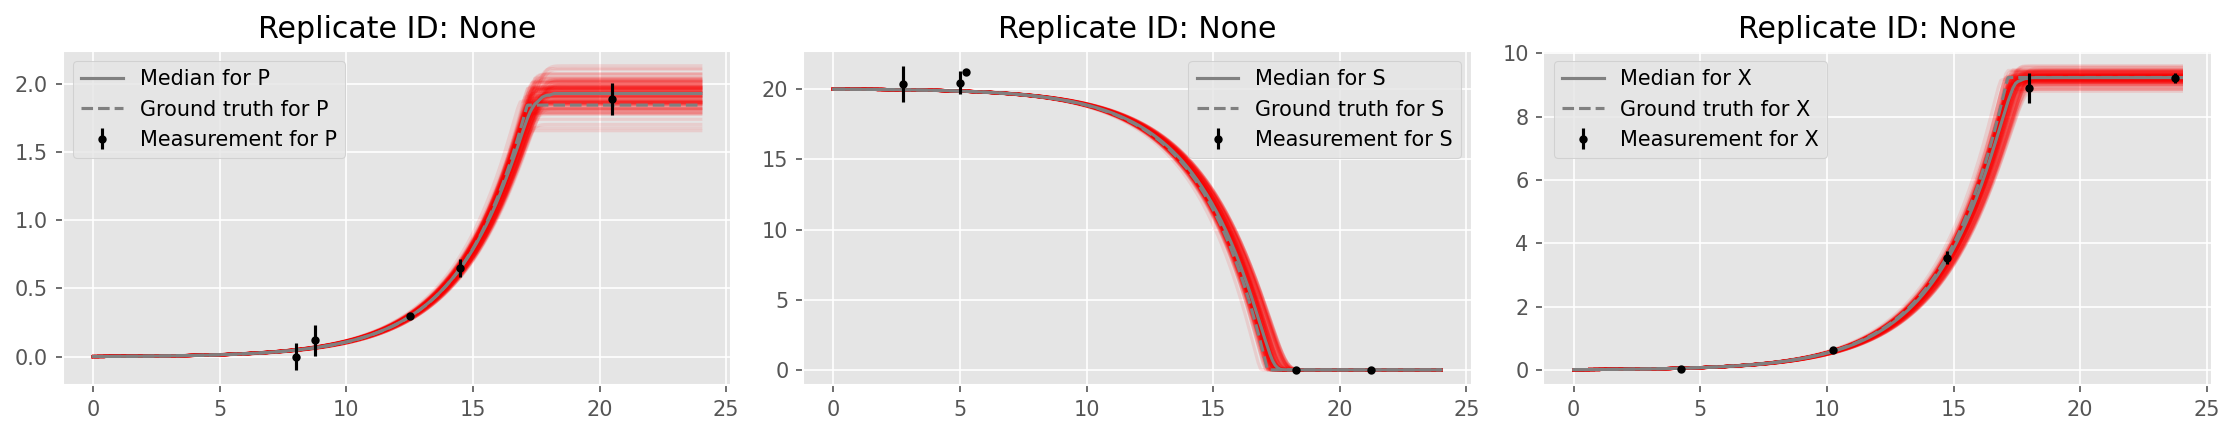

In [16]:
for _estimates in estimates:
    _ = Visualization.compare_estimates_many(
        parameter_collections=_estimates, 
        measurements=data,
        caretaker=caretaker,
        truth=simulation,
    )

### Compare the empirical parameter correlation for the unconstrained and constrained fits

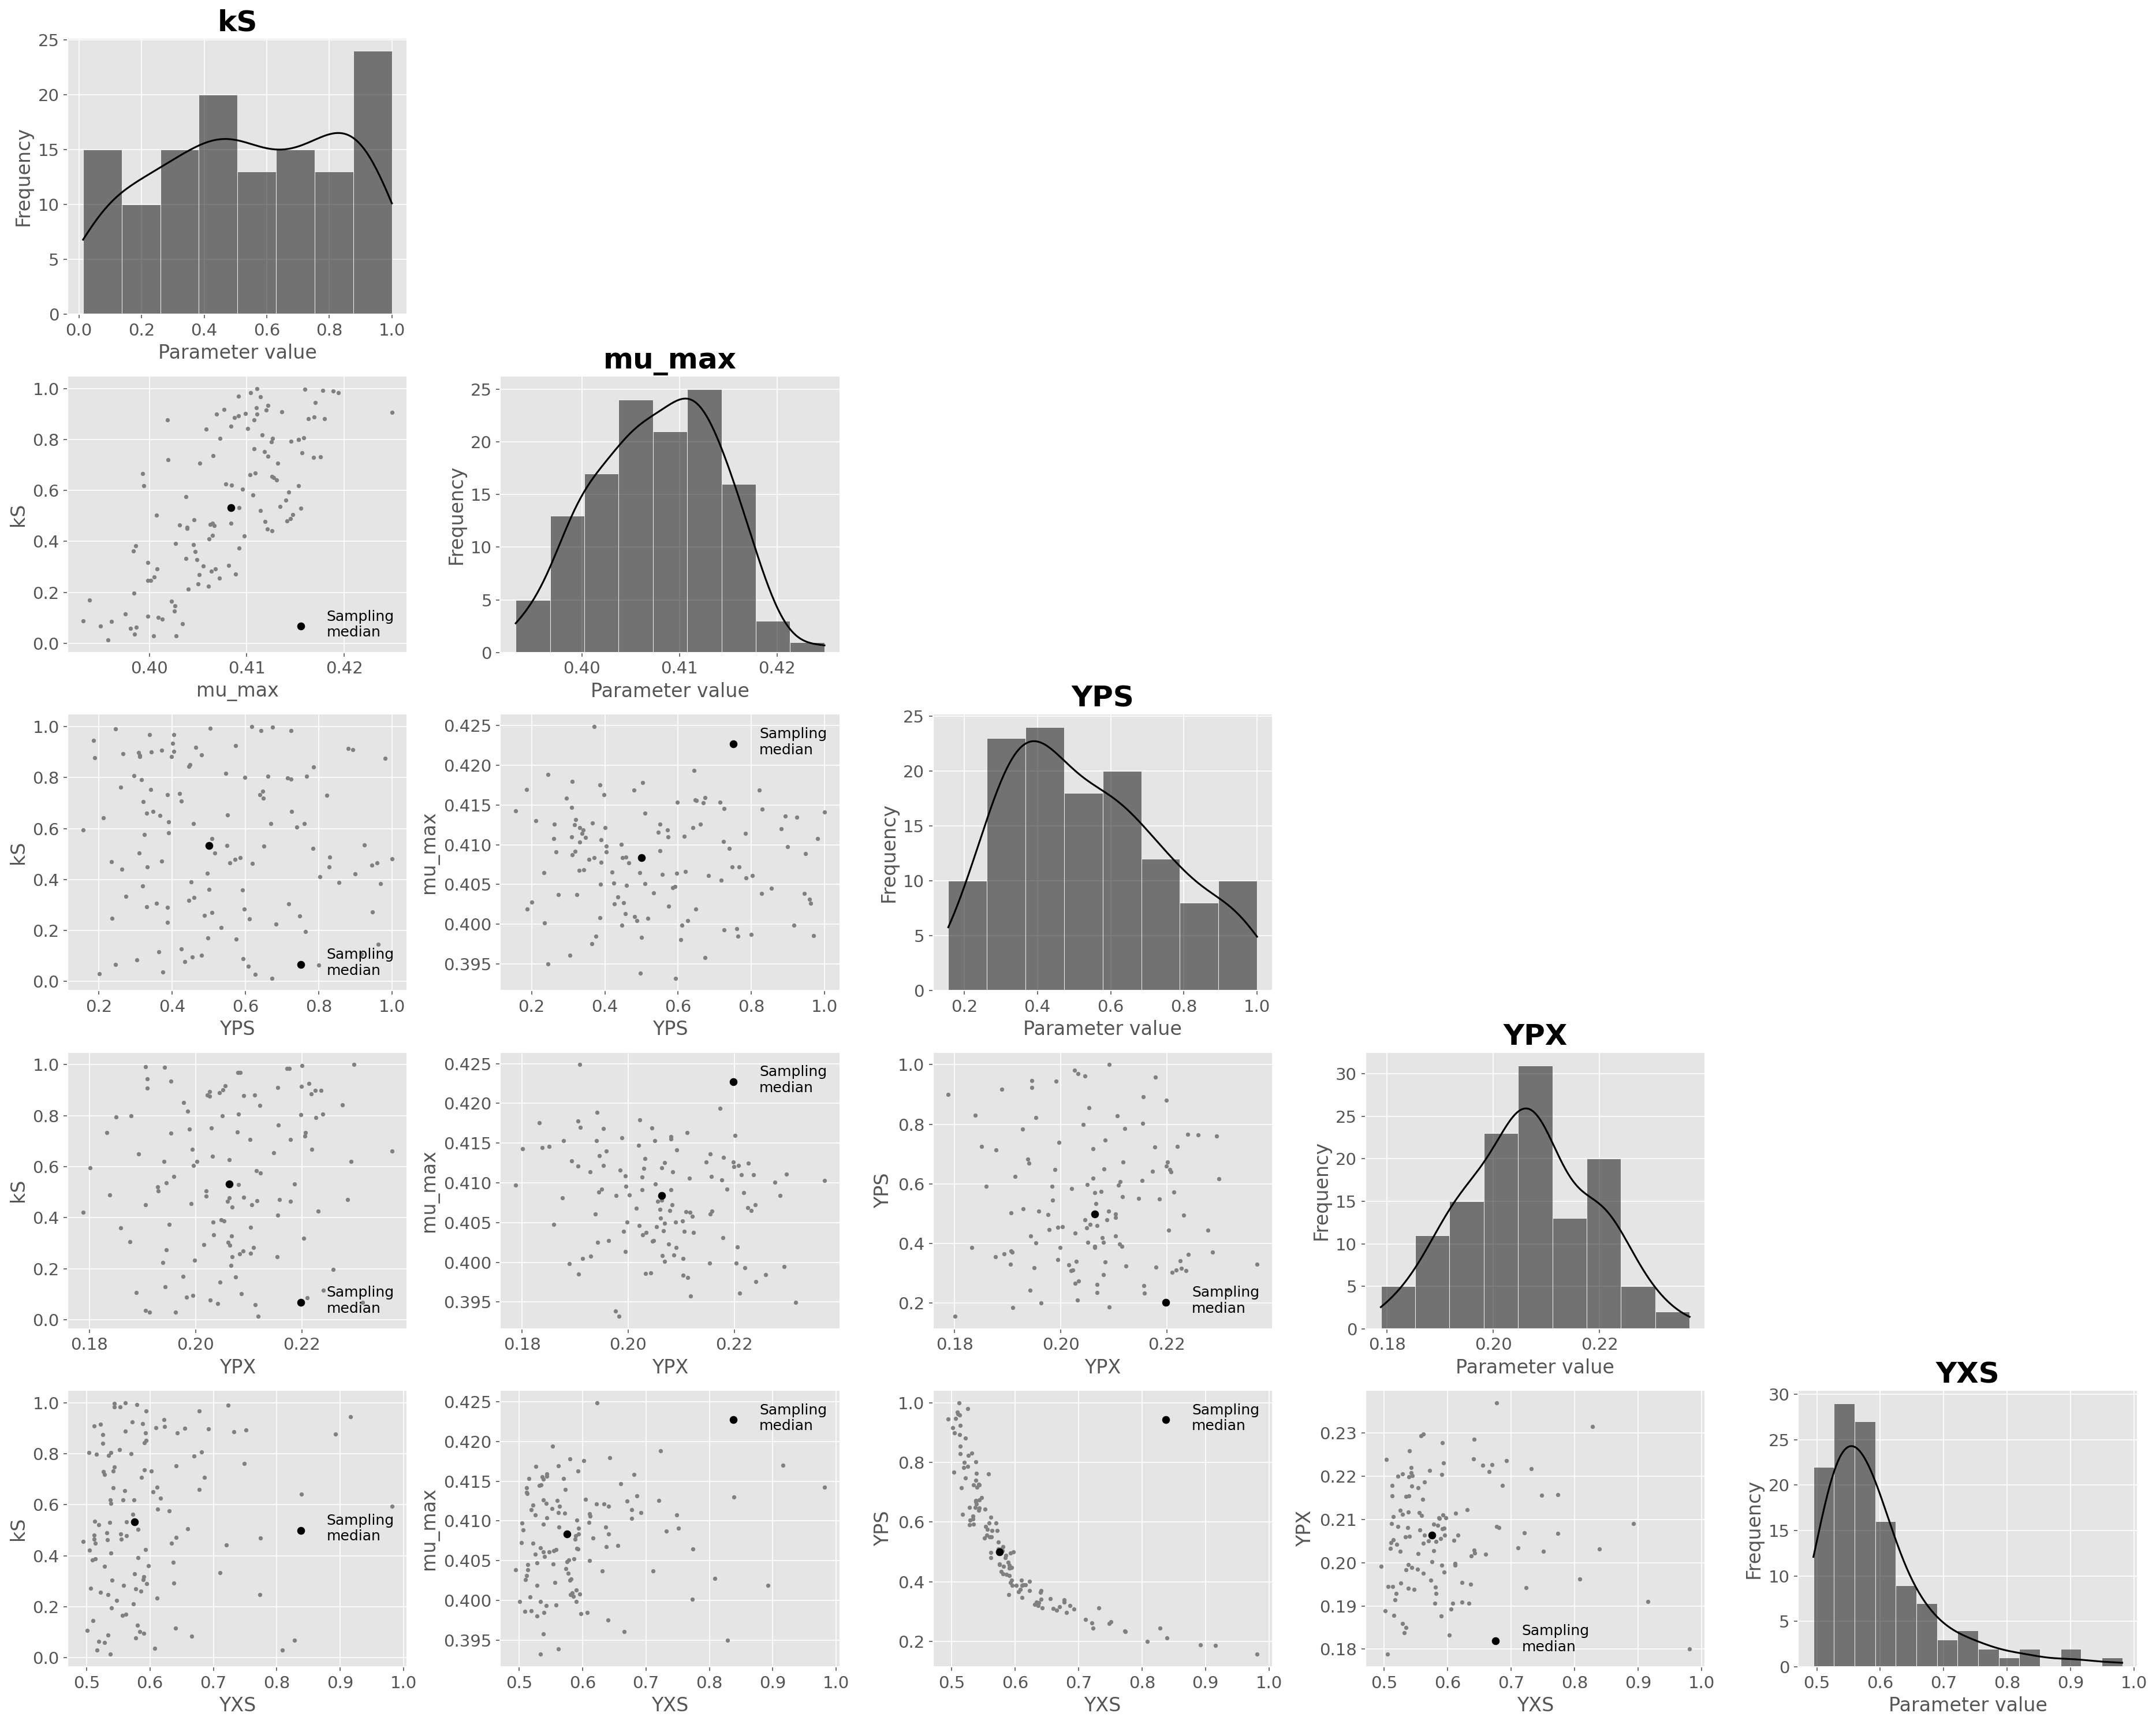

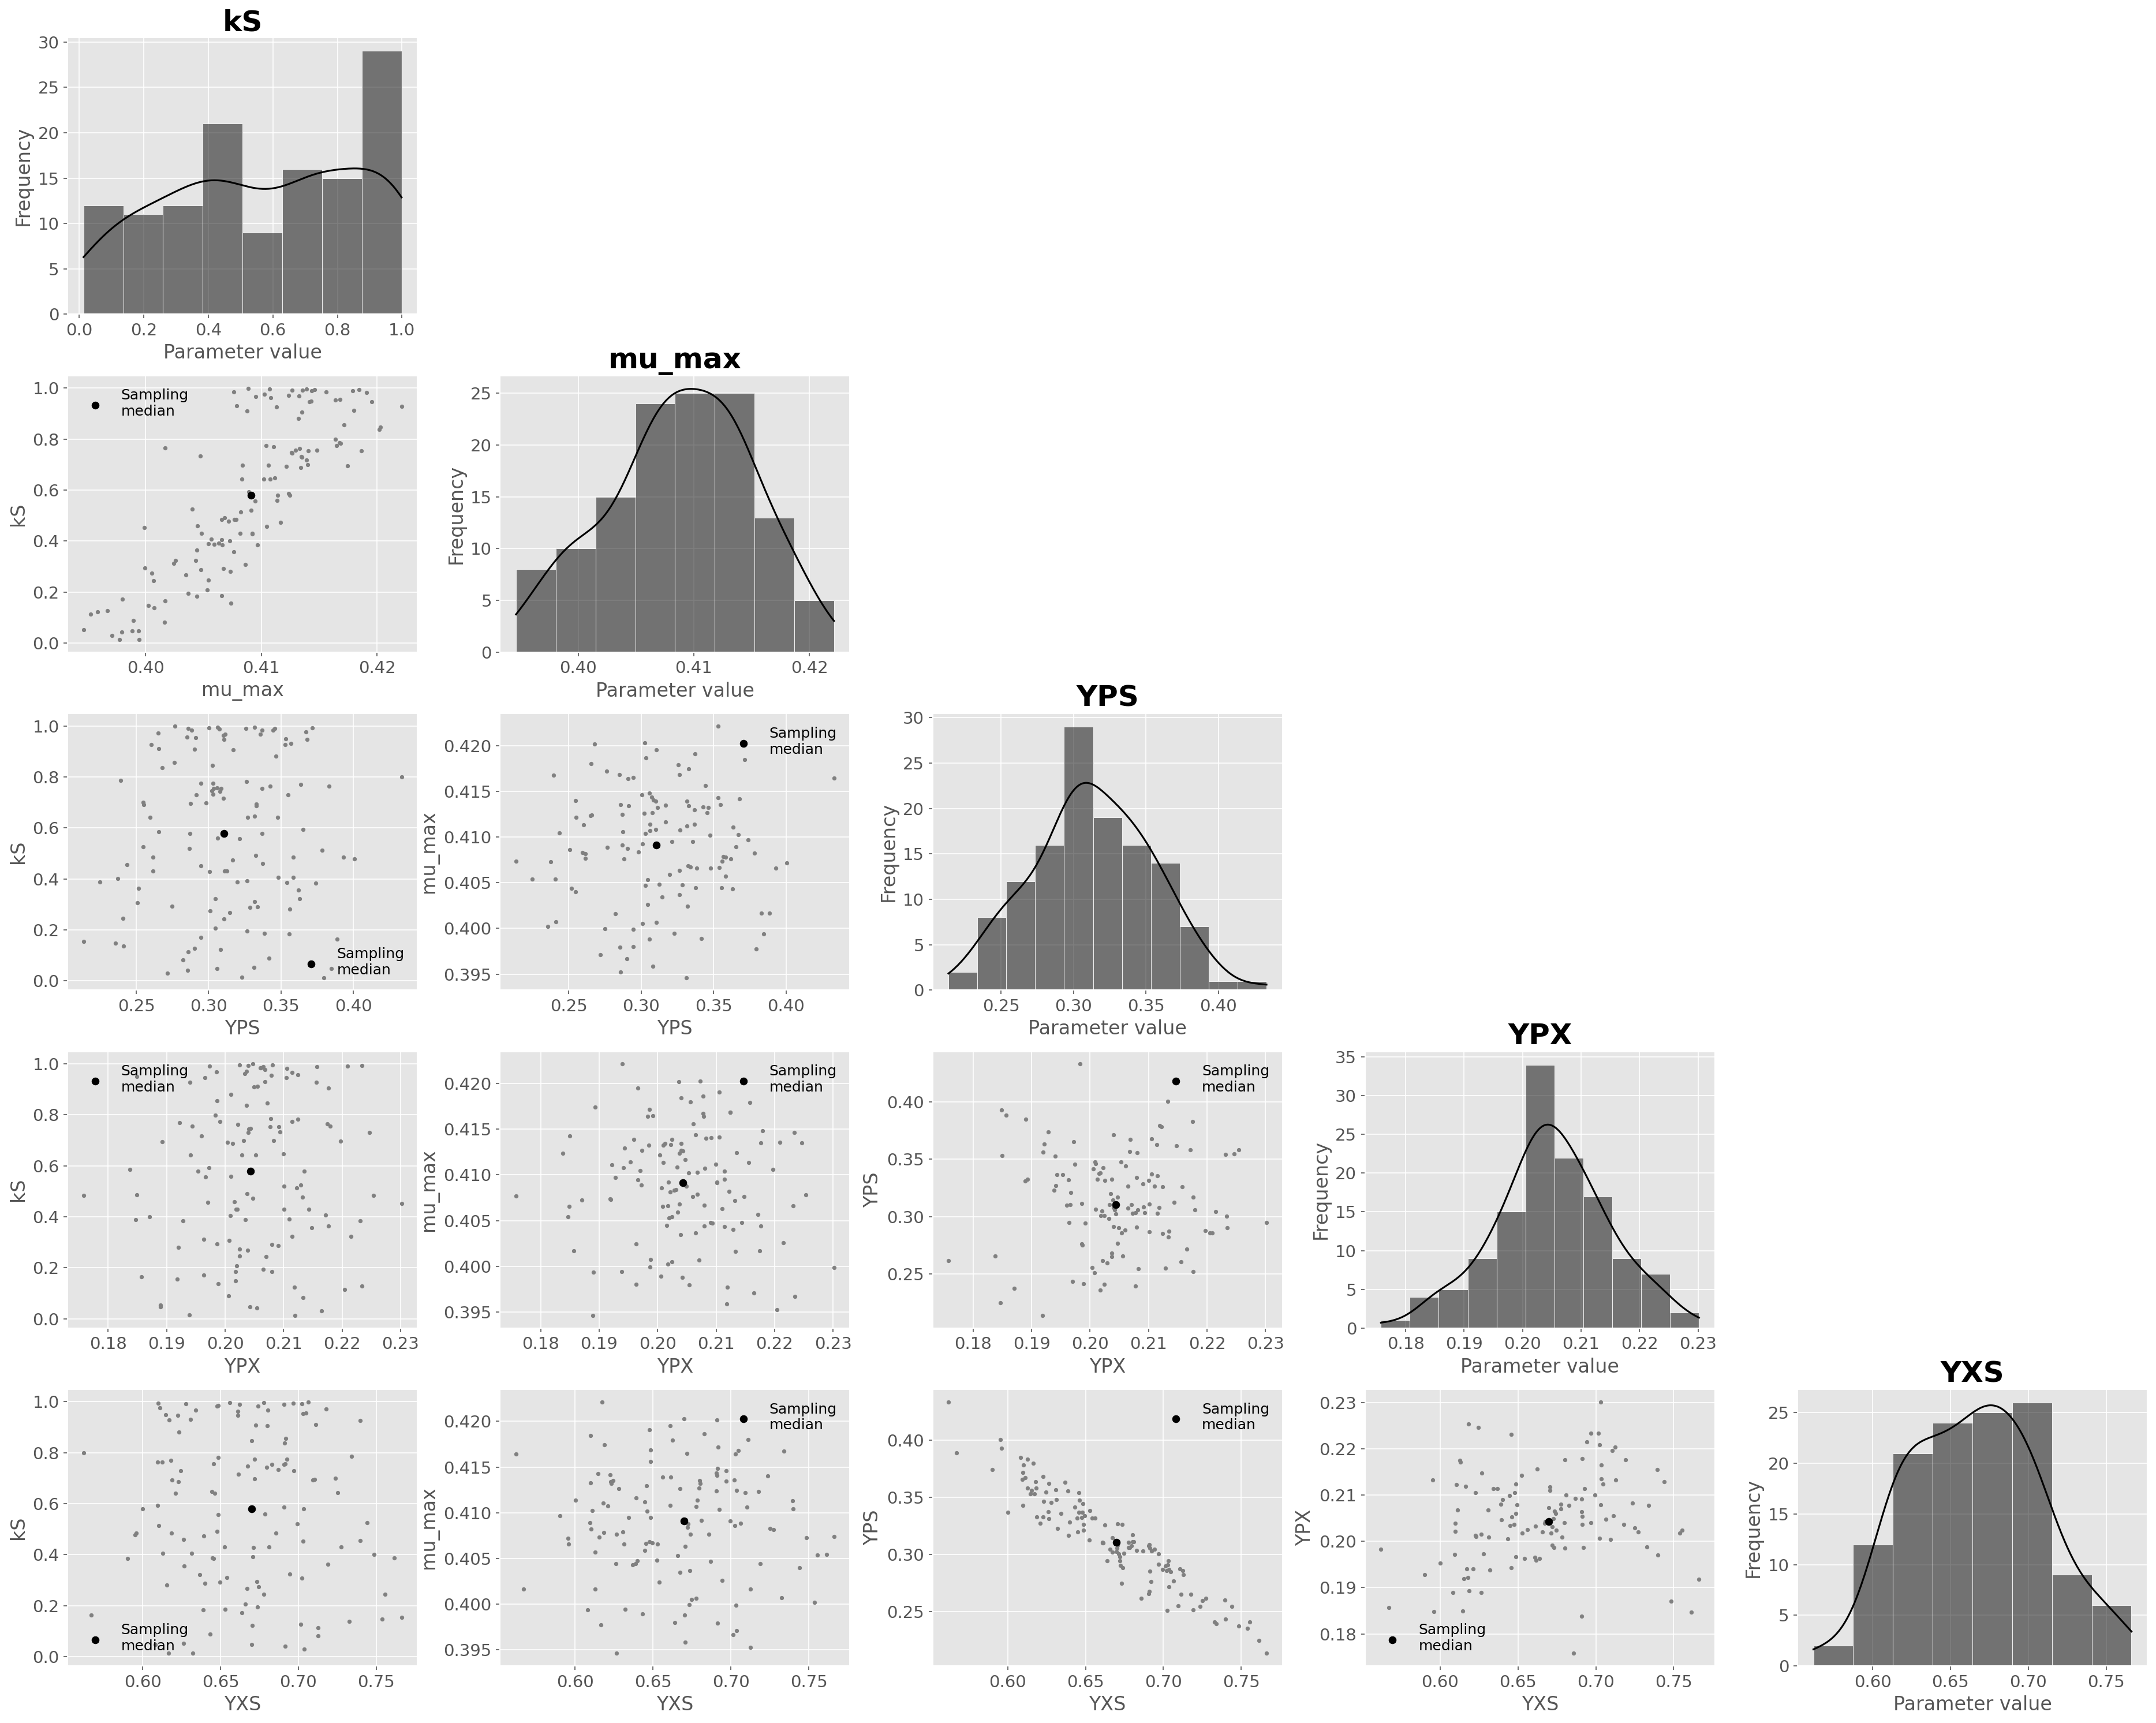

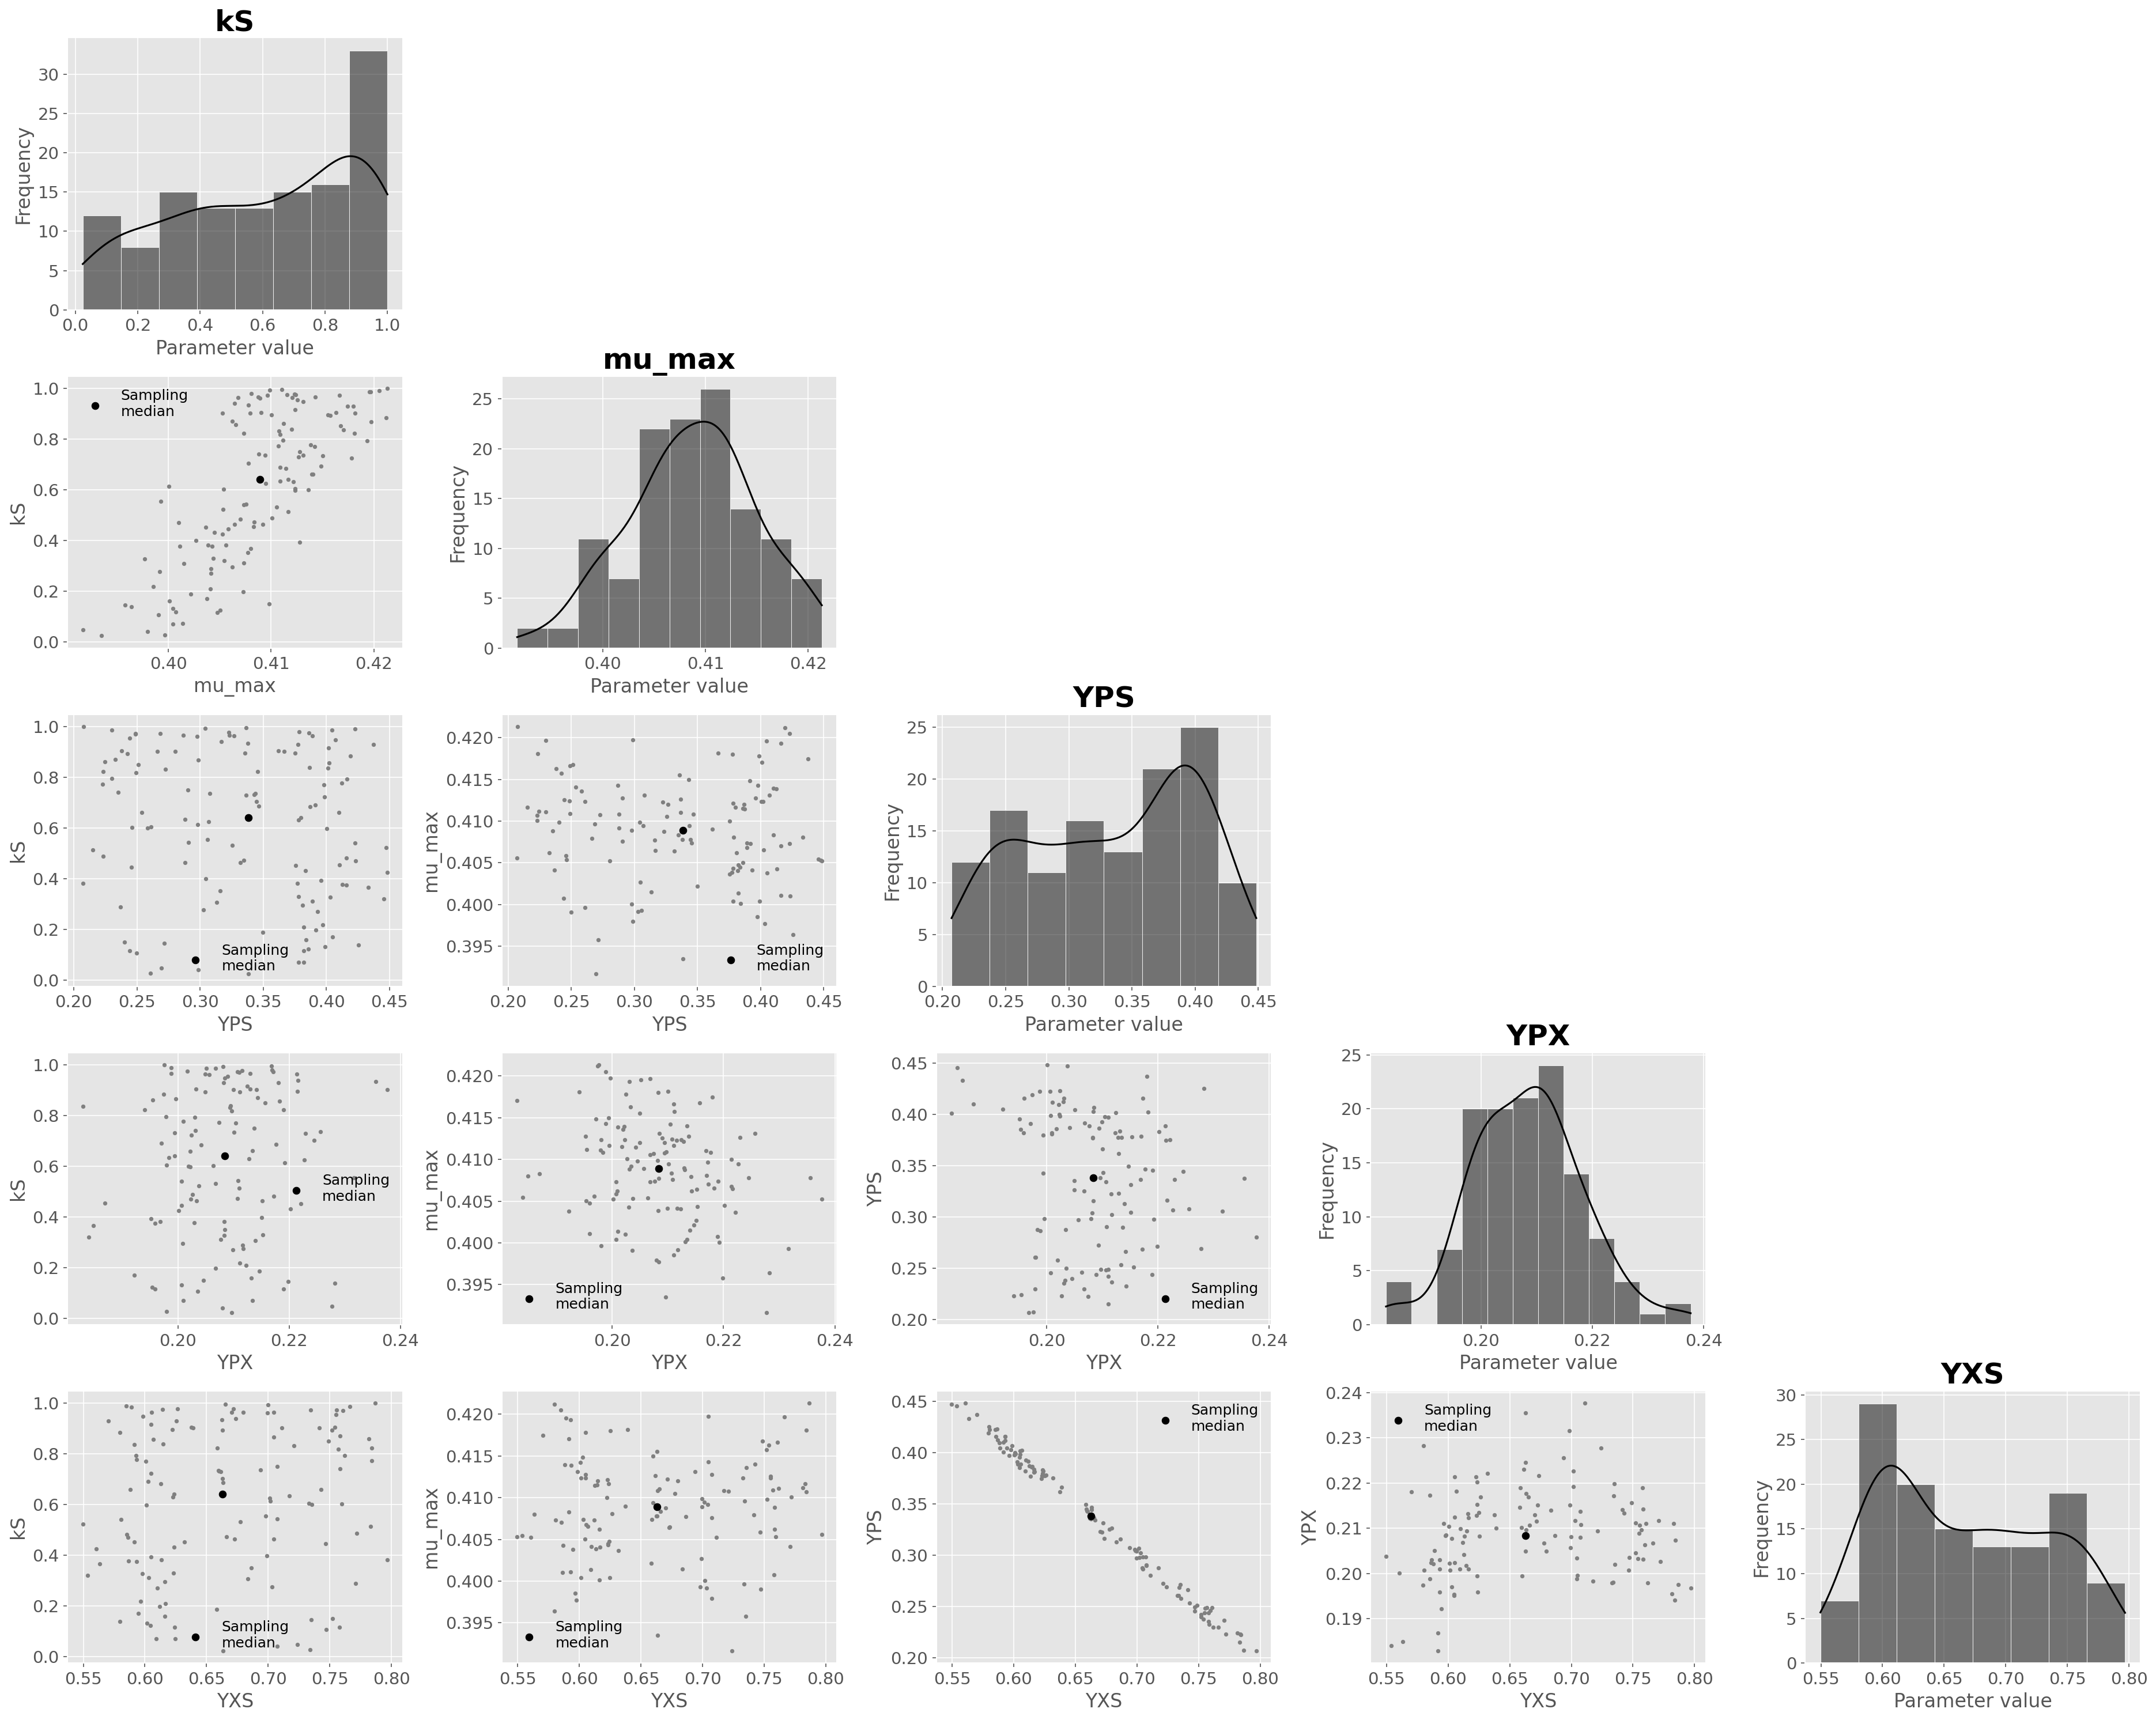

In [17]:
for _estimates in estimates:
    _ = Visualization.show_parameter_distributions(_estimates)